# F1

### Importing data

In [234]:
import pandas as pd
import numpy as np

path = 'C:/Users/gabri/Dropbox/Gaby/Proyectos/My_Portafolio/F1/Data/'

ResultsDF=pd.read_csv(path+"ResultsDF.csv")
QualifyingDF=pd.read_csv(path+"QualifyingDF.csv")
LapsDF=pd.read_csv(path+"LapsDF.csv")
PitsDF=pd.read_csv(path+"PitsDF.csv")

In [239]:
ResultsDF.info()
#ResultsDF.head(21)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7631 entries, 0 to 7630
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     7631 non-null   int64  
 1   number                         7631 non-null   int64  
 2   position                       7631 non-null   int64  
 3   positionText                   7631 non-null   object 
 4   points                         7631 non-null   float64
 5   grid                           7631 non-null   int64  
 6   laps                           7631 non-null   int64  
 7   status                         7631 non-null   object 
 8   Driver.driverId                7631 non-null   object 
 9   Driver.code                    7448 non-null   object 
 10  Driver.url                     7631 non-null   object 
 11  Driver.givenName               7631 non-null   object 
 12  Driver.familyName              7631 non-null   o

In [238]:
LapsDF.info()
#LapsDF.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398292 entries, 0 to 398291
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Unnamed: 0                398292 non-null  int64 
 1   season                    398292 non-null  int64 
 2   round                     398292 non-null  int64 
 3   date                      398292 non-null  object
 4   Circuit.circuitId         398292 non-null  object
 5   Circuit.Location.country  398292 non-null  object
 6   LapNumber                 398292 non-null  int64 
 7   driverId                  398292 non-null  object
 8   position                  398292 non-null  int64 
 9   lap_duration              398292 non-null  object
 10  time                      363641 non-null  object
dtypes: int64(5), object(6)
memory usage: 33.4+ MB


In [237]:
PitsDF.info()
#There are no "easy spotted" missing values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5456 entries, 0 to 5455
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                5456 non-null   int64 
 1   driverId                  5456 non-null   object
 2   lap                       5456 non-null   int64 
 3   stop                      5456 non-null   int64 
 4   time                      5456 non-null   object
 5   duration                  5456 non-null   object
 6   season                    5456 non-null   int64 
 7   round                     5456 non-null   int64 
 8   raceName                  5456 non-null   object
 9   Circuit.circuitId         5456 non-null   object
 10  Circuit.circuitName       5456 non-null   object
 11  Circuit.Location.country  5456 non-null   object
 12  date                      5456 non-null   object
dtypes: int64(5), object(8)
memory usage: 554.2+ KB


### Data Preprocessing (Part 1)

Creating and transforming some features:

In [240]:
#Turning fastestlap into seconds:
ResultsDF[['FastestLap.Time.timeMIN', 'FastestLap.Time.timeSEC']]=ResultsDF['FastestLap.Time.time'].str.split(":", expand=True)
ResultsDF['FastestLap.Time.time_in_seconds']=ResultsDF['FastestLap.Time.timeMIN'].astype(float)*60+ResultsDF['FastestLap.Time.timeSEC'].astype(float)
ResultsDF=ResultsDF.drop(columns=['FastestLap.Time.timeMIN', 'FastestLap.Time.timeSEC'])

#Creating Season-Round feature:
ResultsDF["Season-Round"]=ResultsDF["season"].astype(str)+"-"+ResultsDF["round"].astype(str)

#Transforming lap_duration into seconds:
LapsDF[['lap_durationMIN', 'lap_durationSEC','nothing']]=LapsDF['lap_duration'].str.split(":", expand=True)
LapsDF['lap_duration_in_seconds']=LapsDF['lap_durationMIN'].astype(float)*60+LapsDF['lap_durationSEC'].astype(float)
LapsDF=LapsDF.drop(columns=['lap_durationMIN', 'lap_durationSEC','nothing'])

#Transforming pits duration into seconds:
PitsDF[['durationSEC','nothing']]=PitsDF['duration'].str.split(":", expand=True)
PitsDF['duration_in_seconds']=PitsDF['durationSEC'].astype(float)
PitsDF=PitsDF.drop(columns=['durationSEC','nothing'])

Joining the datasets: Laps+Pits and then adding Results

In [241]:
#Selecting the columns we want to keep from PitsDF
print(PitsDF.columns)
print(LapsDF.columns)

#Renaming certain columns in PitsDF
PitsDF=PitsDF.rename(columns={"lap":'LapNumber',"time":"stop_time","duration_in_seconds":"stop_duration_in_seconds","stop":"stop_number"})

#Features selected to merge with LapsDF
PitsDF[["season","round","driverId","LapNumber","stop_time","stop_duration_in_seconds","stop_number"]].head()

Index(['Unnamed: 0', 'driverId', 'lap', 'stop', 'time', 'duration', 'season',
       'round', 'raceName', 'Circuit.circuitId', 'Circuit.circuitName',
       'Circuit.Location.country', 'date', 'duration_in_seconds'],
      dtype='object')
Index(['Unnamed: 0', 'season', 'round', 'date', 'Circuit.circuitId',
       'Circuit.Location.country', 'LapNumber', 'driverId', 'position',
       'lap_duration', 'time', 'lap_duration_in_seconds'],
      dtype='object')


,season,round,driverId,LapNumber,stop_time,stop_duration_in_seconds,stop_number
0,2012,1,bruno_senna,1,17:05:23,24.599,1
1,2012,1,ricciardo,1,17:05:35,32.319,1
2,2012,1,massa,11,17:21:08,22.313,1
3,2012,1,rosberg,12,17:22:31,23.203,1
4,2012,1,alonso,13,17:24:04,22.035,1


In [242]:
#Joining the selected features from Pits with LapsDF
Laps_Pits=pd.merge(LapsDF,PitsDF[["season","round","driverId","LapNumber","stop_time","stop_duration_in_seconds","stop_number"]],on=["driverId","season","round","LapNumber"],how="left")

#Verifying that the merger was correctly done
#Laps_Pits[Laps_Pits["season"]>=2012].head(20)

In [243]:
#Checking the the timeframes of data available of laps and pits
print("Pits: \n",PitsDF["season"].describe())
print("Laps: \n",LapsDF["season"].describe())

Pits: 
 count    5456.000000
mean     2016.421188
std         2.892644
min      2012.000000
25%      2014.000000
50%      2016.000000
75%      2019.000000
max      2021.000000
Name: season, dtype: float64
Laps: 
 count    398292.000000
mean       2012.350928
std           5.352042
min        2003.000000
25%        2008.000000
50%        2012.000000
75%        2017.000000
max        2021.000000
Name: season, dtype: float64


In [244]:
#We only have information of the pit stops from 2012, so Laps_Pits will have instances from 2012 or later
Laps_Pits=Laps_Pits[Laps_Pits["season"]>=2012]
Laps_Pits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221777 entries, 176515 to 398291
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                221777 non-null  int64  
 1   season                    221777 non-null  int64  
 2   round                     221777 non-null  int64  
 3   date                      221777 non-null  object 
 4   Circuit.circuitId         221777 non-null  object 
 5   Circuit.Location.country  221777 non-null  object 
 6   LapNumber                 221777 non-null  int64  
 7   driverId                  221777 non-null  object 
 8   position                  221777 non-null  int64  
 9   lap_duration              221777 non-null  object 
 10  time                      221777 non-null  object 
 11  lap_duration_in_seconds   221777 non-null  float64
 12  stop_time                 5456 non-null    object 
 13  stop_duration_in_seconds  5456 non-null

In [245]:
#Removing features that are not needed
print(Laps_Pits.columns)
print(Laps_Pits["time"].describe()) #time is unique for all the laps in one race, not relevant for this analysis
#'lap_duration' we already have this feature in seconds
Laps_Pits=Laps_Pits.drop(columns=["Unnamed: 0","time",'lap_duration'])
print(Laps_Pits.columns)

Index(['Unnamed: 0', 'season', 'round', 'date', 'Circuit.circuitId',
       'Circuit.Location.country', 'LapNumber', 'driverId', 'position',
       'lap_duration', 'time', 'lap_duration_in_seconds', 'stop_time',
       'stop_duration_in_seconds', 'stop_number'],
      dtype='object')
count        221777
unique           27
top       12:00:00Z
freq          67218
Name: time, dtype: object
Index(['season', 'round', 'date', 'Circuit.circuitId',
       'Circuit.Location.country', 'LapNumber', 'driverId', 'position',
       'lap_duration_in_seconds', 'stop_time', 'stop_duration_in_seconds',
       'stop_number'],
      dtype='object')


In [247]:
#Adding some columns from ResultsDF to Laps_Pits
print(ResultsDF.columns)

SelectedResults=ResultsDF[['position','points', 'grid','laps', 'status', 'Driver.driverId','Driver.nationality','Constructor.constructorId','Constructor.nationality','Season-Round','season', 'round','FastestLap.rank', 'FastestLap.lap', 'FastestLap.Time.time_in_seconds',
    'FastestLap.AverageSpeed.units', 'FastestLap.AverageSpeed.speed']][ResultsDF["season"]>=2012]

#Renaming certain columns in SelectedResults
SelectedResults=SelectedResults.rename(columns={"position":'position_final_race',"laps":"laps_total_race","Driver.driverId":"driverId"})

Laps_Pits_Results=pd.merge(Laps_Pits,SelectedResults,on=["driverId","season","round"],how="left")

Laps_Pits_Results.head(21)

Index(['Unnamed: 0', 'number', 'position', 'positionText', 'points', 'grid',
       'laps', 'status', 'Driver.driverId', 'Driver.code', 'Driver.url',
       'Driver.givenName', 'Driver.familyName', 'Driver.dateOfBirth',
       'Driver.nationality', 'Constructor.constructorId', 'Constructor.url',
       'Constructor.name', 'Constructor.nationality', 'Time.millis',
       'Time.time', 'Driver.permanentNumber', 'season', 'round', 'raceName',
       'Circuit.circuitId', 'Circuit.circuitName', 'Circuit.Location.country',
       'date', 'FastestLap.rank', 'FastestLap.lap', 'FastestLap.Time.time',
       'FastestLap.AverageSpeed.units', 'FastestLap.AverageSpeed.speed',
       'FastestLap.Time.time_in_seconds', 'Season-Round'],
      dtype='object')


,season,round,date,Circuit.circuitId,Circuit.Location.country,LapNumber,driverId,position,lap_duration_in_seconds,stop_time,...,status,Driver.nationality,Constructor.constructorId,Constructor.nationality,Season-Round,FastestLap.rank,FastestLap.lap,FastestLap.Time.time_in_seconds,FastestLap.AverageSpeed.units,FastestLap.AverageSpeed.speed
0,2012,1,2012-03-18,albert_park,Australia,1,button,1,99.264,NaN,...,Finished,British,mclaren,British,2012-1,1.0,56.0,89.187,kph,214.053
1,2012,1,2012-03-18,albert_park,Australia,1,hamilton,2,100.622,NaN,...,Finished,British,mclaren,British,2012-1,4.0,57.0,89.538,kph,213.214
2,2012,1,2012-03-18,albert_park,Australia,1,michael_schumacher,3,102.002,NaN,...,Gearbox,German,mercedes,German,2012-1,18.0,4.0,94.021,kph,203.048
3,2012,1,2012-03-18,albert_park,Australia,1,rosberg,4,102.666,NaN,...,Finished,German,mercedes,German,2012-1,14.0,53.0,90.931,kph,209.948
4,2012,1,2012-03-18,albert_park,Australia,1,vettel,5,103.029,NaN,...,Finished,German,red_bull,Austrian,2012-1,2.0,57.0,89.417,kph,213.503
5,2012,1,2012-03-18,albert_park,Australia,1,grosjean,6,103.730,NaN,...,Collision,French,lotus_f1,British,2012-1,NaN,NaN,NaN,NaN,NaN
6,2012,1,2012-03-18,albert_park,Australia,1,maldonado,7,104.212,NaN,...,Accident,Venezuelan,williams,British,2012-1,5.0,53.0,90.254,kph,211.523
7,2012,1,2012-03-18,albert_park,Australia,1,alonso,8,104.733,NaN,...,Finished,Spanish,ferrari,Italian,2012-1,7.0,52.0,90.277,kph,211.469
8,2012,1,2012-03-18,albert_park,Australia,1,webber,9,105.336,NaN,...,Finished,Australian,red_bull,Austrian,2012-1,3.0,57.0,89.438,kph,213.452
9,2012,1,2012-03-18,albert_park,Australia,1,massa,10,106.714,NaN,...,Collision,Brazilian,ferrari,Italian,2012-1,15.0,46.0,91.940,kph,207.644


### Premliminar EDA

In [219]:
import seaborn as sns
import matplotlib.pyplot as plt

#### I. How fast are the cars now?

##### The fastest lap per round (race) from season 2014 to season 2021 per driver

In this graph we can see the fastest lap, per race, per driver, and per season. As from 2014 until the present, there have been a lot of drivers racing in F1, the legend show as the nationality of the driver. The label at the bottom of each point from each year also show us the name of the driver who did had the fastest lap of the season.

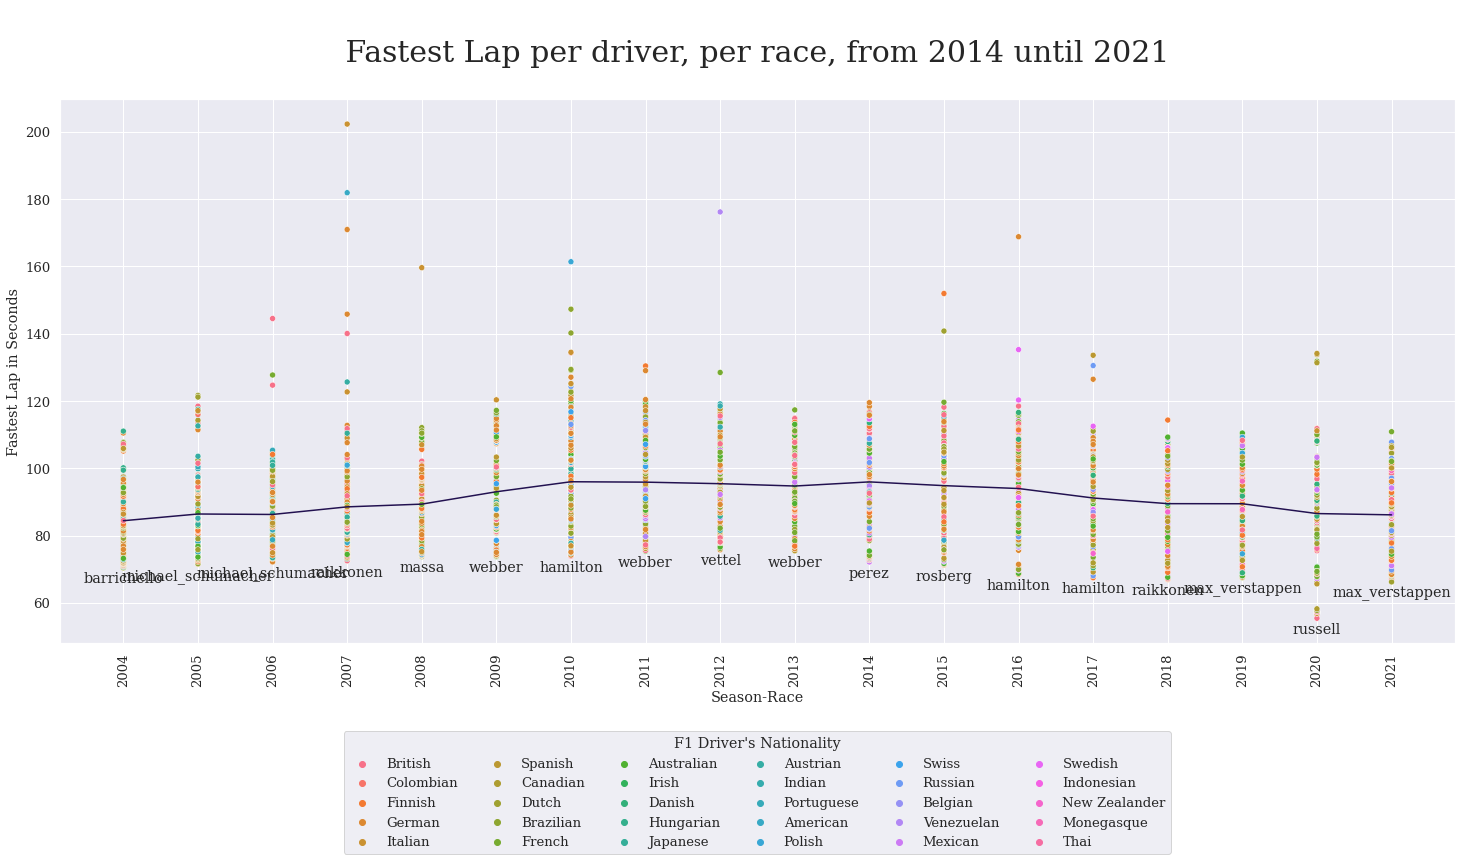

In [140]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.2,font="serif")
Years=ResultsDF["season"].unique().tolist() #or seasons for plot

#Fastest lap per driver per season
LABELS=pd.DataFrame(columns=["Driver.driverId","FastestLap.Time.time_in_seconds","season"])
for i in ResultsDF[ResultsDF["season"]>=2004]["season"].unique().tolist():
    A=pd.DataFrame(ResultsDF[ResultsDF["season"]==i].groupby(["Driver.driverId"])["FastestLap.Time.time_in_seconds"].min())
    A["season"]=i
    Selected=A[A["FastestLap.Time.time_in_seconds"]==min(A["FastestLap.Time.time_in_seconds"])].reset_index()
    LABELS=pd.concat([LABELS,Selected])

#Plot
fig, ax = plt.subplots(figsize=(25, 10))
sns.scatterplot(x="season", y="FastestLap.Time.time_in_seconds",hue='Driver.nationality',ci=None,estimator="min",
           data=ResultsDF)
sns.lineplot(x="season", y="FastestLap.Time.time_in_seconds",estimator="mean",ci=None,
           data=ResultsDF)

plt.locator_params(axis="x", nbins = len(Years))
plt.title("\n Fastest Lap per driver, per race, from 2014 until 2021 \n",fontsize=30)
plt.xlabel("Season-Race")
plt.ylabel("Fastest Lap in Seconds")
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(0.5, -0.4),loc='lower center', title="F1 Driver's Nationality", ncol=6)


#Individual labels of the fastest lap of the season:
for label,y,x in LABELS.to_numpy():
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center


plt.show()



##### Top speed per round from 2014 until 2021 per driver

This plot shows the top speed per race, per driver, per season. It also contains the team of each driver. Hamilton has been the fastest for 7 seasons with Mercedes! It is important to mention that the speed in which cars go depend on the mechanical regulations that the FIA has for each year. We would think that overtime, cars should get faster. Well, that doesn't happen because teams are obliged to satisfy safety and racing mechanical regulations per year.

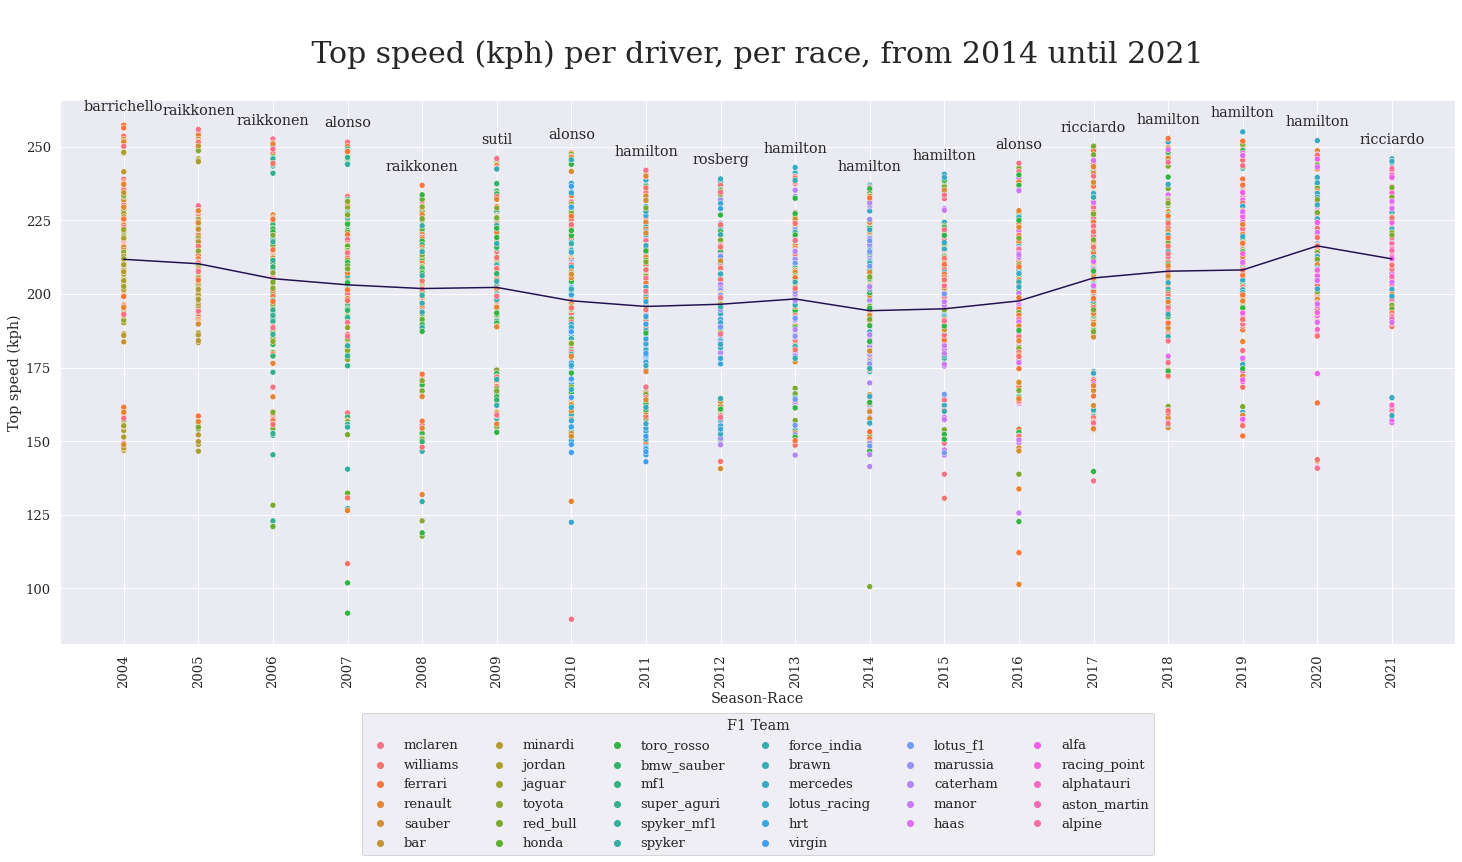

In [139]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.2,font="serif")
Years=ResultsDF["season"].unique().tolist() #or seasons for plot

#Top speed per driver per season
LABELS=pd.DataFrame(columns=["Driver.driverId",'FastestLap.AverageSpeed.speed',"season"])
for i in ResultsDF[ResultsDF["season"]>=2004]["season"].unique().tolist():
    A=pd.DataFrame(ResultsDF[ResultsDF["season"]==i].groupby(["Driver.driverId"])['FastestLap.AverageSpeed.speed'].max())
    A["season"]=i
    Selected=A[A['FastestLap.AverageSpeed.speed']==max(A['FastestLap.AverageSpeed.speed'])].reset_index()
    LABELS=pd.concat([LABELS,Selected])

#Plot
fig, ax = plt.subplots(figsize=(25, 10))
sns.scatterplot(x="season", y='FastestLap.AverageSpeed.speed',hue='Constructor.constructorId',ci=None,estimator="max",
           data=ResultsDF)
sns.lineplot(x="season", y='FastestLap.AverageSpeed.speed',estimator="mean",ci=None,
           data=ResultsDF)

plt.locator_params(axis="x", nbins = len(Years))
plt.title("\n Top speed (kph) per driver, per race, from 2014 until 2021 \n",fontsize=30)
plt.xlabel("Season-Race")
plt.ylabel("Top speed (kph)")
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(0.5, -0.4),loc='lower center', title="F1 Team", ncol=6)


#Individual labels of the fastest lap of the season:
for label,y,x in LABELS.to_numpy():
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center


plt.show()


##### Top speed (kph) comparison per team in the last 10 years

In the last 10 years, the F1 has been dominated by Mercedes and Red Bull. This can be seen in the top speed of their cars. In seasons 2011, 2012, and 2013, Red Bull had the highest average top speeds during the season. However, from 2014 and later, this place was taken by Mercedes (except 2017 where Ferrari took the lead).

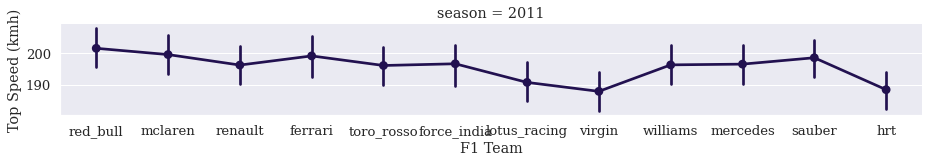

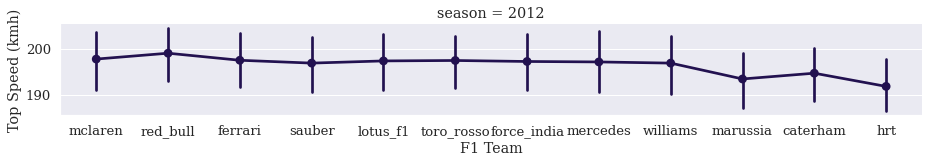

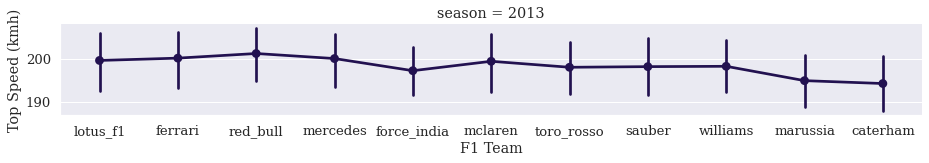

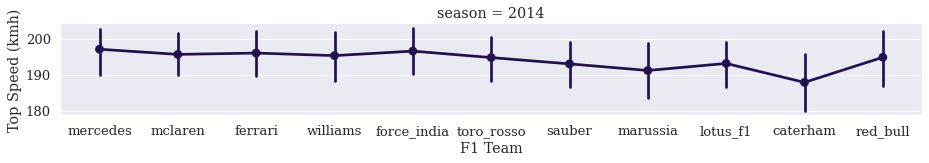

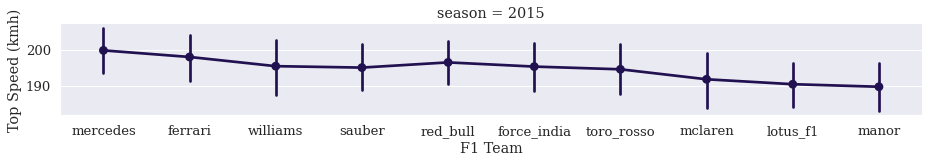

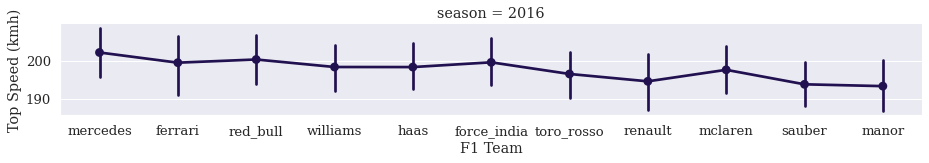

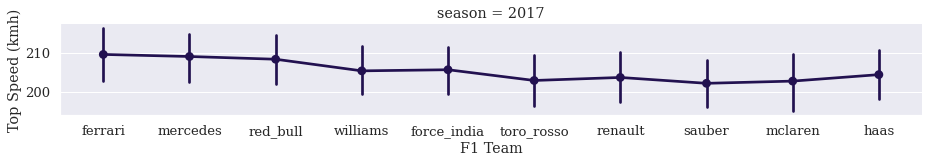

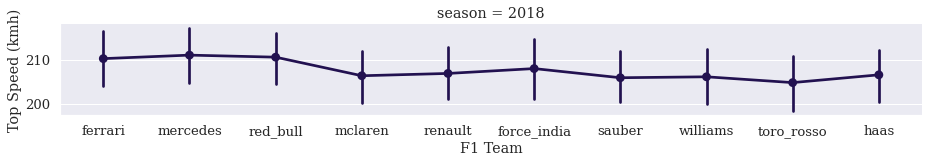

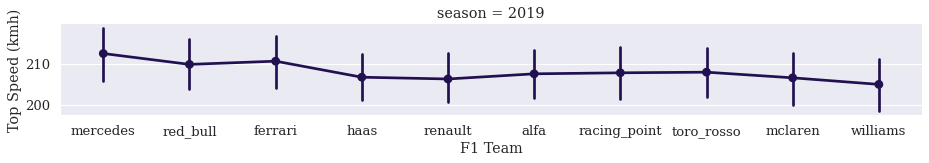

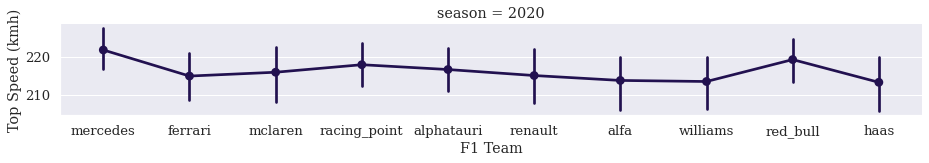

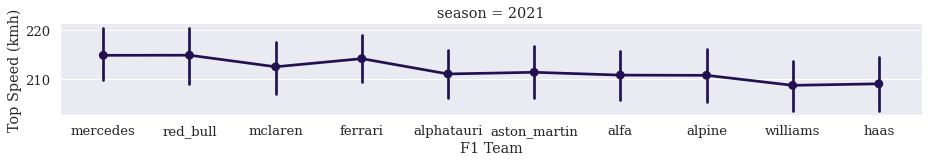

In [161]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1.2,font="serif")


#Plot
for i in Years:
    if i<=2010:
        continue
    else:
        g = sns.catplot(x='Constructor.constructorId', y='FastestLap.AverageSpeed.speed',
        col="season",kind="point",col_wrap=3,height=2.5,aspect=5,
                data=ResultsDF[ResultsDF["season"]==i])
        plt.xlabel("F1 Team")
        plt.ylabel("Top Speed (kmh)")

plt.show()


##### Fastest lap comparison between circuits (2021)

This analysis was done using last 2021 as reference. The fastest circuit in 2021 was the Red Bull Ring and the slowest, Baku.

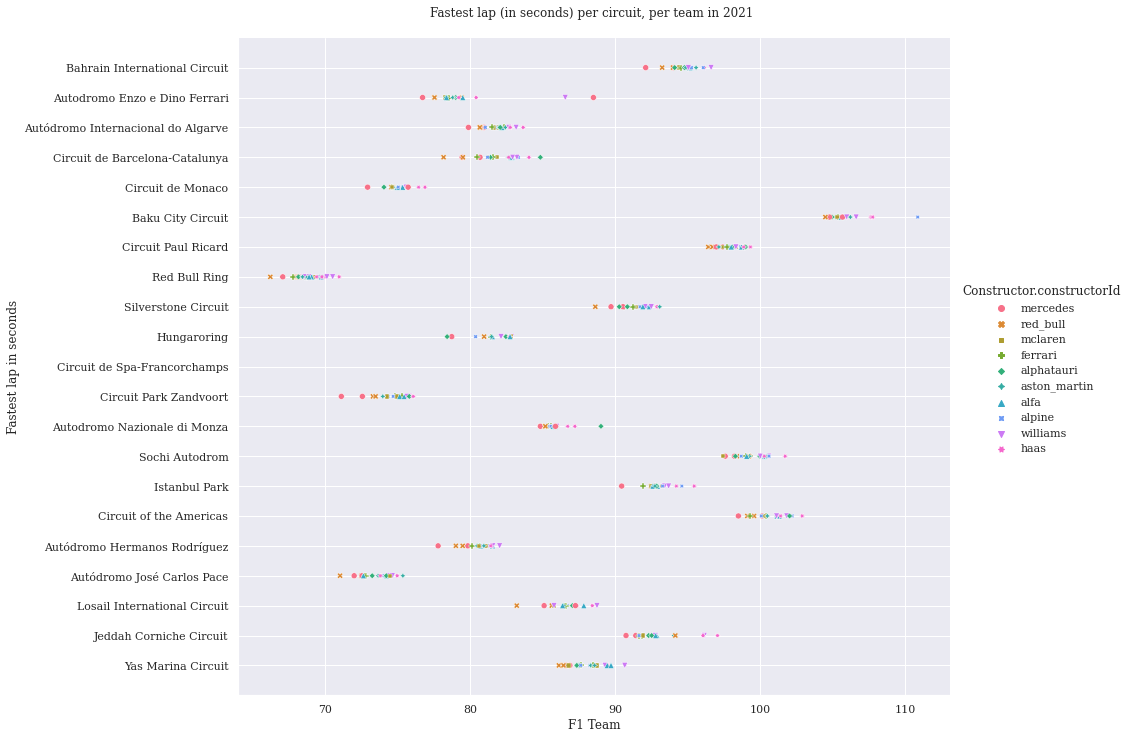

In [191]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1,font="serif")

g = sns.relplot(x="FastestLap.Time.time_in_seconds", y='Circuit.circuitName',hue='Constructor.constructorId',height=10,aspect=1.4,
        style='Constructor.constructorId',data=ResultsDF[ResultsDF["season"]==2021])
plt.title("Fastest lap (in seconds) per circuit, per team in 2021 \n")
plt.xlabel("F1 Team")
plt.ylabel("Fastest lap in seconds")


plt.show()


##### Average duration of each lap per circuit

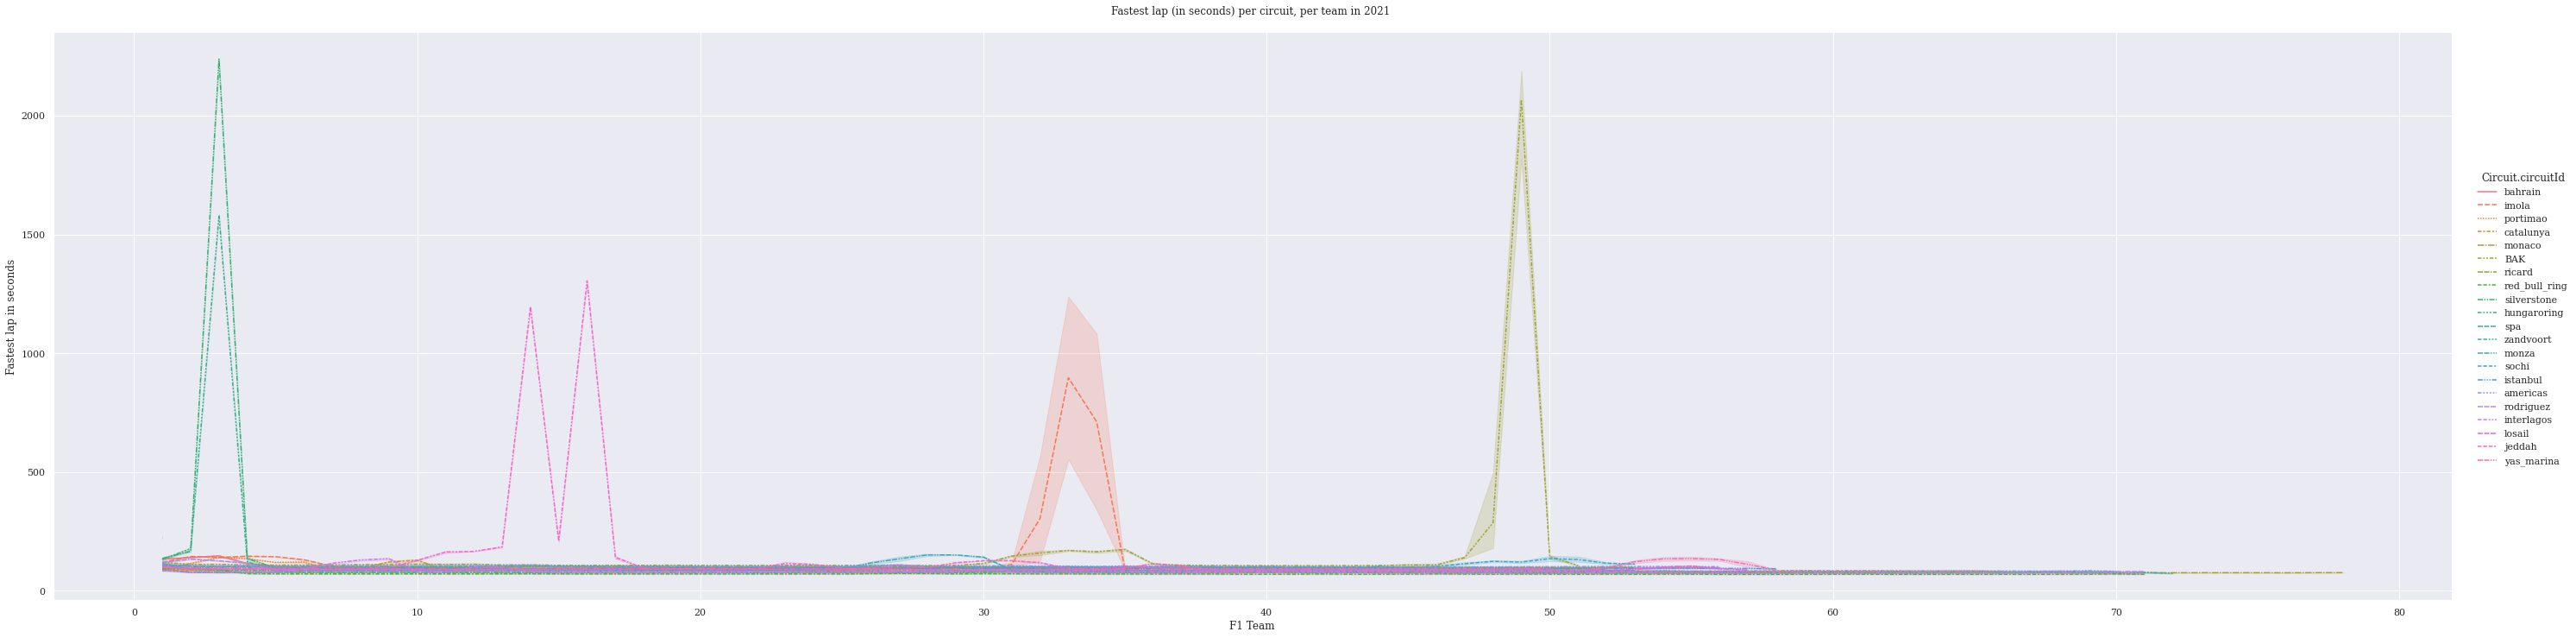

In [211]:
sns.set_theme(style="darkgrid", palette="magma",font_scale=1,font="serif")

g = sns.relplot(x="LapNumber", y='lap_duration_in_seconds',hue='Circuit.circuitId',height=10,aspect=4,kind="line",
        ,data=LapsDF[LapsDF["season"]==2021])
plt.title("Fastest lap (in seconds) per circuit, per team in 2021 \n")
plt.xlabel("F1 Team")
plt.ylabel("Fastest lap in seconds")


plt.show()


In [208]:
LapsDF.columns



Index(['Unnamed: 0', 'season', 'round', 'date', 'Circuit.circuitId',
       'Circuit.Location.country', 'LapNumber', 'driverId', 'position',
       'lap_duration', 'time', 'lap_duration_in_seconds'],
      dtype='object')

### Other Stuff

In [158]:
#Adding some columns from ResultsDF to Laps_Pits
print(ResultsDF.columns)

SelectedResults=ResultsDF[['position','points', 'grid','laps', 'status', 'Driver.driverId','Driver.nationality','Constructor.constructorId','Constructor.nationality','season', 'round','FastestLap.rank', 'FastestLap.lap', 'FastestLap.Time.time',
       'FastestLap.AverageSpeed.units', 'FastestLap.AverageSpeed.speed']][ResultsDF["season"]>=2012]

#Renaming certain columns in SelectedResults
SelectedResults=SelectedResults.rename(columns={"position":'position_final',"laps":"laps_race","Driver.driverId":"driverId"})

Laps_Pits_Results=pd.merge(Laps_Pits,SelectedResults,on=["driverId","season","round"],how="left")

Laps_Pits_Results

Index(['Unnamed: 0', 'number', 'position', 'positionText', 'points', 'grid',
       'laps', 'status', 'Driver.driverId', 'Driver.code', 'Driver.url',
       'Driver.givenName', 'Driver.familyName', 'Driver.dateOfBirth',
       'Driver.nationality', 'Constructor.constructorId', 'Constructor.url',
       'Constructor.name', 'Constructor.nationality', 'Time.millis',
       'Time.time', 'Driver.permanentNumber', 'season', 'round', 'raceName',
       'Circuit.circuitId', 'Circuit.circuitName', 'Circuit.Location.country',
       'date', 'FastestLap.rank', 'FastestLap.lap', 'FastestLap.Time.time',
       'FastestLap.AverageSpeed.units', 'FastestLap.AverageSpeed.speed'],
      dtype='object')


,season,round,date,Circuit.circuitId,Circuit.Location.country,LapNumber,driverId,position,lap_duration,stop_time,...,laps_race,status,Driver.nationality,Constructor.constructorId,Constructor.nationality,FastestLap.rank,FastestLap.lap,FastestLap.Time.time,FastestLap.AverageSpeed.units,FastestLap.AverageSpeed.speed
0,2012,1,2012-03-18,albert_park,Australia,1,button,1,1:39.264,NaN,...,58,Finished,British,mclaren,British,1.0,56.0,1:29.187,kph,214.053
1,2012,1,2012-03-18,albert_park,Australia,1,hamilton,2,1:40.622,NaN,...,58,Finished,British,mclaren,British,4.0,57.0,1:29.538,kph,213.214
2,2012,1,2012-03-18,albert_park,Australia,1,michael_schumacher,3,1:42.002,NaN,...,10,Gearbox,German,mercedes,German,18.0,4.0,1:34.021,kph,203.048
3,2012,1,2012-03-18,albert_park,Australia,1,rosberg,4,1:42.666,NaN,...,58,Finished,German,mercedes,German,14.0,53.0,1:30.931,kph,209.948
4,2012,1,2012-03-18,albert_park,Australia,1,vettel,5,1:43.029,NaN,...,58,Finished,German,red_bull,Austrian,2.0,57.0,1:29.417,kph,213.503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222770,2021,22,2021-12-12,yas_marina,UAE,58,ocon,9,1:28.249,NaN,...,58,Finished,French,alpine,French,10.0,58.0,1:28.249,kph,215.431
222771,2021,22,2021-12-12,yas_marina,UAE,58,leclerc,10,1:29.557,NaN,...,58,Finished,Monegasque,ferrari,Italian,12.0,40.0,1:28.433,kph,214.983
222772,2021,22,2021-12-12,yas_marina,UAE,58,leclerc,10,1:29.557,NaN,...,58,Finished,Monegasque,ferrari,Italian,12.0,40.0,1:28.433,kph,214.983
222773,2021,22,2021-12-12,yas_marina,UAE,58,vettel,11,1:28.303,NaN,...,58,Finished,German,aston_martin,British,11.0,58.0,1:28.303,kph,215.299


In [69]:
#Checking the the timeframes of data available of laps and pits
#print("Pits: \n",PitsDF["season"].describe())
#print("Laps: \n",LapsDF["season"].describe())
Laps_Pits[(Laps_Pits["driverId"]=='resta') & (Laps_Pits["Circuit.circuitId"]=='sepang')]
#Pits information is available from 2012, so Laps_Pits(the analysis) will contain information only from 2012 forward:
Laps_Pits.info()
#ResultsDF[(ResultsDF["Driver.driverId"]=='resta') & (ResultsDF["Circuit.circuitId"]=='sepang') & (ResultsDF["season"]==2013)]
#ResultsDF["status"].unique()
#for i in Laps_Pits["stop_duration"].unique():
#    print(i)


#Changing the type of certain features (when needed)
print("Before changes:",Laps_Pits.info())
#types_to_convert={"date":'datetime64[ns]',"stop_duration":"float64","stop_number":"int64"}
types_to_convert={"stop_duration":float}
Laps_Pits["flo"]=Laps_Pits["stop_duration"].astype(float)

print("After changes:",Laps_Pits.info())
Laps_Pits[Laps_Pits["season"]>=2012].head(21)

#Fastest lap per driver per season
LABELS=pd.DataFrame(columns=["Driver.driverId","FastestLap.Time.time_in_seconds","season"])
All_Fastest=pd.DataFrame(columns=["Driver.driverId","FastestLap.Time.time_in_seconds","season"])
for i in ResultsDF[ResultsDF["season"]>=2004]["season"].unique().tolist():
    A=pd.DataFrame(ResultsDF[ResultsDF["season"]==i].groupby(["Driver.driverId"])["FastestLap.Time.time_in_seconds"].min())
    A["season"]=i
    Selected=A[(A["FastestLap.Time.time_in_seconds"]==min(A["FastestLap.Time.time_in_seconds"])) | (A["FastestLap.Time.time_in_seconds"]==max(A["FastestLap.Time.time_in_seconds"]))].reset_index()
    All_Fastest=pd.concat([All_Fastest,A])
    LABELS=pd.concat([LABELS,Selected])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398292 entries, 0 to 398291
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   season                    398292 non-null  int64  
 1   round                     398292 non-null  int64  
 2   date                      398292 non-null  object 
 3   Circuit.circuitId         398292 non-null  object 
 4   Circuit.Location.country  398292 non-null  object 
 5   LapNumber                 398292 non-null  int64  
 6   driverId                  398292 non-null  object 
 7   position                  398292 non-null  int64  
 8   lap_duration              398292 non-null  object 
 9   time                      363641 non-null  object 
 10  stop_time                 5456 non-null    object 
 11  stop_duration             5456 non-null    object 
 12  stop_number               5456 non-null    float64
dtypes: float64(1), int64(4), object(8)
memory us